In [1]:
import numpy as np

## Softmax

Обобщение логистической функции для многомерного случая. Функция преобразует вектор $z$ размерности $K$ в вектор $\sigma$ той же размерности, где каждая координата $\sigma_i$ полученного вектора представлена вещественным числом в интервале $[0,1]$ и сумма координат равна 1.

Координаты $\sigma_i$ вычисляются следующим образом:


${\displaystyle \sigma (z)_{i}={\frac {e^{z_{i}}}{\displaystyle \sum _{k\mathop {=} 1}^{K}e^{z_{k}}}}}$

1. Реализуйте функцию softmax, которая на вход принимает вектор $z$, а на выходе считает от него софтмакс.
2. Добавьте возможность принимать на вход матрицу и считать softmax по столбцам (батч)

In [2]:
# 1
def softmax(z):
    z = np.array(z)
    denominator = np.exp(z).sum()
    smz = np.exp(z) / denominator
    return smz

In [3]:
z = np.array([1,2,3])
softmax(z)

array([ 0.09003057,  0.24472847,  0.66524096])

In [4]:
softmax(z).sum()

1.0

In [5]:
# 2
def softmax_col(z):
    z = np.array(z)
    denominator = np.exp(z).sum(axis = 0)
    smz = (np.exp(z) / denominator)
    return smz

In [6]:
z = np.array([[1,2,3],
              [1,1,1],
              [9,9,9],
              [8,7,6]])
softmax_col(z)

array([[  2.45122603e-04,   8.02301516e-04,   2.35488234e-03],
       [  2.45122603e-04,   2.95150233e-04,   3.18698669e-04],
       [  7.30700181e-01,   8.79830446e-01,   9.50027343e-01],
       [  2.68809574e-01,   1.19072103e-01,   4.72990763e-02]])

In [7]:
softmax_col(z).sum(axis=0)

array([ 1.,  1.,  1.])

## Дивергенция Кульбака-Лейблера

* Показать что $D_{KL}(p||q) \ge 0$ для любых $p$ и $q$. Для этого можно воспользоваться [формулой Йенсена](https://en.wikipedia.org/wiki/Jensen%27s_inequality "неравенство Йенсена")
* ~~Показать, что максимизация правдопобия эквивалентна минимизации $D_{KL}$~~. 

<img src='firstn.jpg'>

## GLM

На слайде 27 в лекциях показывается, что распределение Бернулли входит в экспоненциальное семейство. Чему равно $\phi$?

<img src='secondn.jpg'>

## Обучение линейных моделей

Буквально три-четыре года назад для того, чтобы обучить нейронную сеть было необходимо вручную вычислить градиент функции потерь. Затем, обычно, правильность решения проверялась численно. После появления фреймворков вроде Theano и TF это стало необязательным, благодаря чему исследователи и инженеры могут проводить свои эксперименты значительно быстрее. В данной работе мы посчитаем и проверим градиенты для линейных моделей, рассмотренных на первой лекции; а так же в явном виде реализуем алгоритм оптимизации.      

In [1]:
import numpy as np
from keras.datasets import cifar10
from random import randrange
import time

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train.shape

(50000, 32, 32, 3)

Визуализируем классы

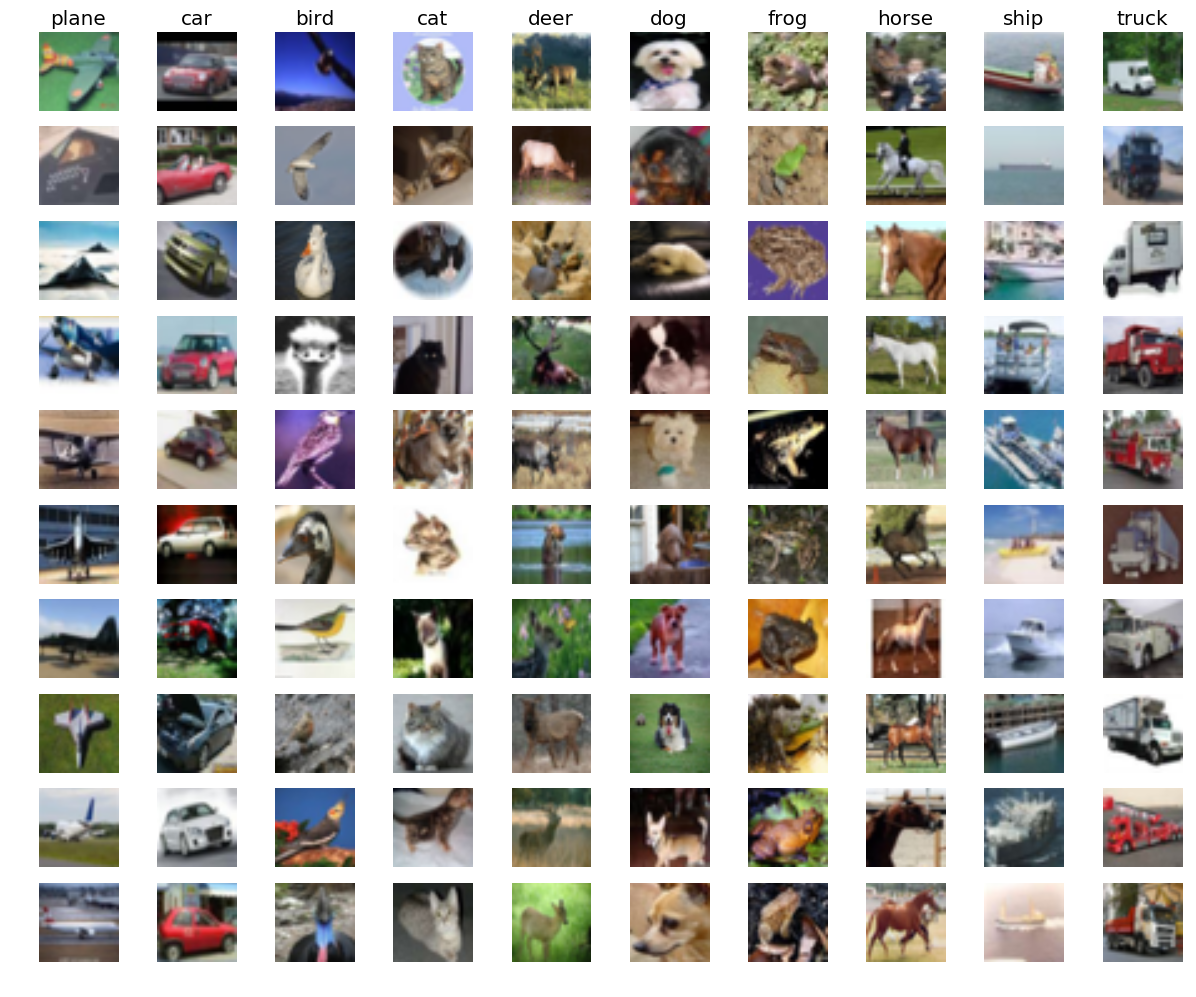

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[ 130.71074  136.05614  132.5538   130.14036  135.44238  131.85358
  131.05044  136.24616  132.58144  131.56886]


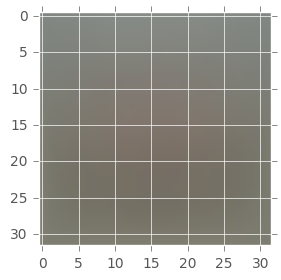

In [7]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
plt.figure(figsize=(3,3))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

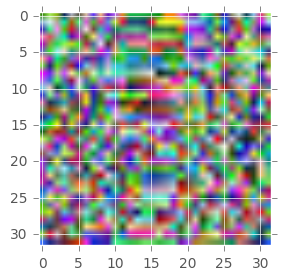

In [8]:
plt.figure(figsize=(3,3))
plt.imshow(mean_image.reshape((32,32,3))) # визуализируем полученное среднее
plt.show()

In [9]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [10]:
print(x_train.shape)

(50000, 3072)


In [11]:
# 3: Добавляем новую компоненту отвечающую за сдвиг (bias trick)
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

In [12]:
print(x_train.shape)

(50000, 3073)


**Задача 1:** Далее следует функция svm_loss, которую вам предстоит дописать.

In [13]:
def svm_loss(W, X, y, reg):
    """
    SVM loss function
    Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    y = y.flatten()
    W = W.T.copy()
    
    loss = 0
    dW = np.zeros(W.shape)
    num_train = X.shape[0]

    scores = X.dot(W)
    yi_scores = scores[np.arange(scores.shape[0]),y] # http://stackoverflow.com/a/23435843/459241 
    margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)
    margins[np.arange(num_train),y] = 0
    loss = np.mean(np.sum(margins, axis=1))
    
    loss += 0.5 * reg * np.sum(np.array(W) * np.array(W))
    
    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    
    binary = margins
    binary[margins > 0] = 1
    row_sum = np.sum(binary, axis=1)
    binary[np.arange(num_train), y] = -row_sum.T
    dW = np.dot(X.T, binary)

    # Average
    dW /= num_train

    # Regularize
    dW += reg*W

    return loss, dW.T

In [14]:
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001

In [15]:
loss, grad = svm_loss(W, x_test, y_test, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.835790


In [16]:
#При помощи этой функции можно проверить градиент численно 
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """
    h = 1e-5

    x.shape
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        x[ix] += h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] -= 2 * h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] += h # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [17]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = svm_loss(W, x_test, y_test, 0.0)

# Проверяем численно
f = lambda w: svm_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Проверяем численно, используя регуляризацию.
# Вы ведь не забыли реализовать регуляризацию, правда? 
loss, grad = svm_loss(W, x_test, y_test, 5e1)
f = lambda w: svm_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 6.026485 analytic: 6.022781, relative error: 3.074211e-04
numerical: 6.602444 analytic: 6.598836, relative error: 2.733094e-04
numerical: 21.311535 analytic: 21.323743, relative error: 2.863296e-04
numerical: -2.460309 analytic: -2.465199, relative error: 9.928627e-04
numerical: -11.246577 analytic: -11.241718, relative error: 2.160936e-04
numerical: 8.817980 analytic: 8.817980, relative error: 1.318169e-12
numerical: 0.014863 analytic: 0.010110, relative error: 1.903343e-01
numerical: 39.211450 analytic: 39.207010, relative error: 5.662861e-05
numerical: -21.959552 analytic: -21.961865, relative error: 5.266094e-05
numerical: -8.635740 analytic: -8.635740, relative error: 9.609195e-13
numerical: 27.363063 analytic: 27.357961, relative error: 9.324243e-05
numerical: -4.422741 analytic: -4.422741, relative error: 3.705445e-12
numerical: 6.961728 analytic: 6.961728, relative error: 1.677743e-12
numerical: 6.026982 analytic: 6.025494, relative error: 1.234692e-04
numerical: -5.

**Задача 2:** Реализуйте методы класса SVM. Для тренировки используйте градиентный спуск.

In [173]:
class SVM():
    def __init__(self):
        self.W = np.random.randn(10, 3073) * 0.0001 
        
    def fit(self, x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True):
        loss_history = []
        for it in range(num_iters):
            Loss, dL = svm_loss(self.W, x_train, y_train, reg)
            self.W = (self.W - learning_rate*dL)
            loss_history.append(Loss)
            
            if verbose:
                if it%100==0:
                    print(it, Loss)

        return loss_history
    
    def predict(self, X):
        pred = X.dot(self.W.T)
        return np.argmax(np.array(pred), axis=1).reshape(pred.shape[0],1)

Проверяем полученную реализацию.

In [142]:
tic = time.time()
svm = SVM()
loss_hist = svm.fit(x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

0 13.018437269
50 8.36836730159
100 7.46528843199
150 6.86310779495
200 6.42215572333
250 6.08999912157
300 5.83687281424
350 5.6427393301
400 5.49327383175
450 5.37792567097
500 5.28879041954
550 5.21982820485
600 5.16642063585
650 5.1250452874
700 5.09298752165
750 5.06813216168
800 5.04885636096
850 5.03390291566
900 5.02230232022
950 5.01329863458
That took 738.216353s


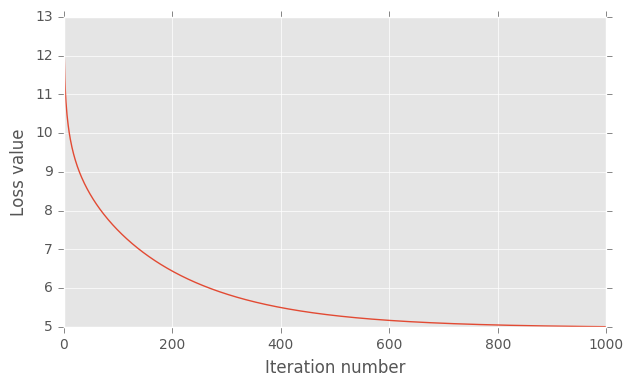

In [26]:
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации
plt.figure(figsize=(7,4))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [27]:
# Теперь вычислим точность на тренировочном и тестовом множествах
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(x_test)
print('validation accuracy: %f' % (np.mean(y_test == y_val_pred), ))

training accuracy: 0.386360
validation accuracy: 0.383200


In [55]:
def plot_weights(best_svm):
    w = best_svm.W[:,:-1] # strip out the bias
    w = np.array(w).reshape(10, 32, 32, 3)
    w_min, w_max = np.min(w), np.max(w)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(10):
        plt.subplot(2, 5, i + 1)

        # Rescale the weights to be between 0 and 255
        wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
        plt.imshow(wimg.astype('uint8'))
        plt.axis('off')
        plt.title(classes[i])

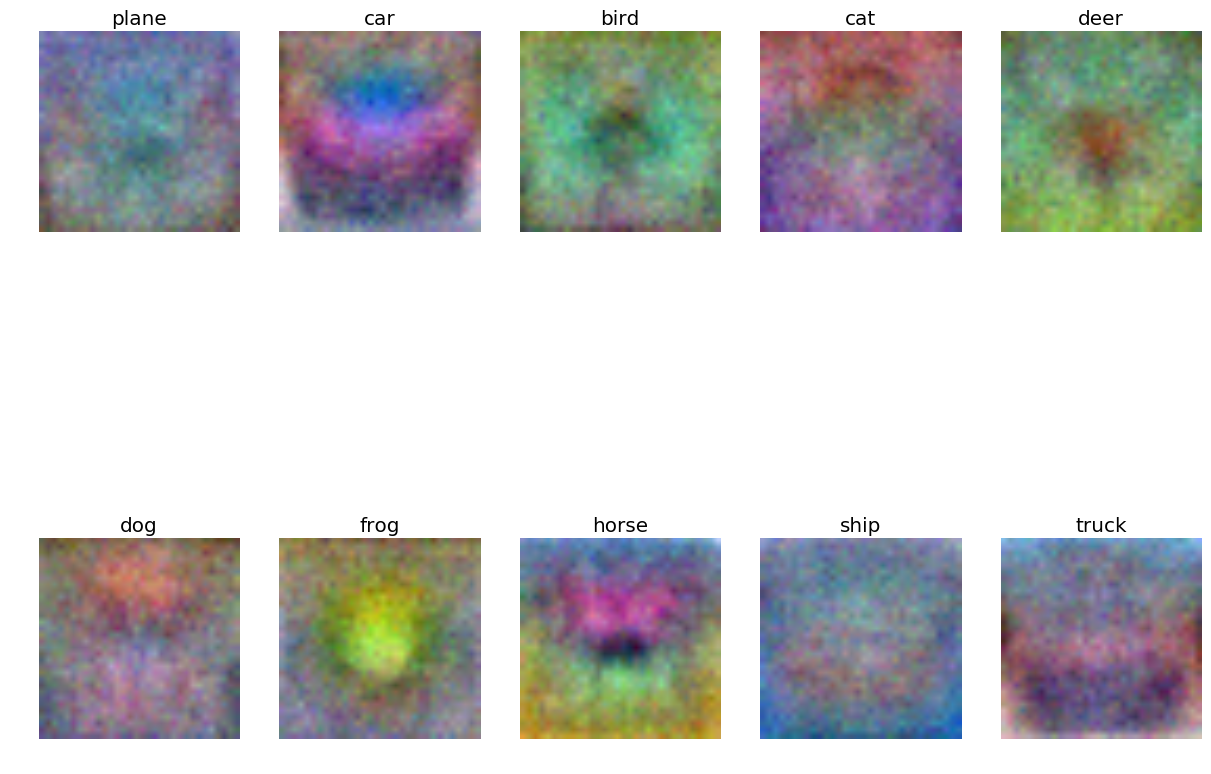

In [56]:
plot_weights(svm)

**Задача 3:** Подберите при помощи поиска по сетке наулучшие параметры learning rate и regularization coefficient. Для полученной модели вызовите функцию plot_weights(best_svm). Впишите свой код под этой ячейкой.

In [143]:
parameters = {'learning_rate':(1e-9, 1e-7, 0.0001, 0.01), 'reg':[3.5e4, 2.5e4, 15000, 5000, 1000]}

In [174]:
gridsearch_res = []
for i in range(4):
    for j in range(5):
        svm = SVM()
        loss_hist = svm.fit(x_train, y_train, 
                            learning_rate=parameters['learning_rate'][i],
                            reg=parameters['reg'][j],
                            num_iters=800,
                            verbose=True)
        y_train_pred = svm.predict(x_train)
        y_val_pred = svm.predict(x_test)
        
        print(i, j)
        
        gridsearch_res.append(
            [
                parameters['learning_rate'][i],
                parameters['reg'][j],
                np.mean(y_train == y_train_pred),
                np.mean(y_test == y_val_pred),
                svm
            ]
        )

0 14.3112079846
100 13.5059461774
200 12.8987196796
300 12.5034385224
400 12.2314272519
500 12.0240248688
600 11.8534330815
700 11.7065354409
0 0
0 12.8664967338
100 12.1448045065
200 11.6055915541
300 11.2259503376
400 10.9481809532
500 10.7304595807
600 10.5514474893
700 10.39995613
0 1
0 11.2946506815
100 10.5289389233
200 9.97092520904
300 9.60950968801
400 9.35700573443
500 9.16260278802
600 9.00405372434
700 8.87111059407
0 2
0 9.57708892305
100 8.90970736848
200 8.43102508877
300 8.0921717568
400 7.84304927176
500 7.6514306377
600 7.49701997081
700 7.36869127553
0 3
0 8.69503796576
100 8.10650270751
200 7.70462936254
300 7.4227588215
400 7.21101419671
500 7.04307108678
600 6.90395253503
700 6.78562661018
0 4
0 14.6661281358
100 7.84102825505
200 6.42361476129
300 5.75097046864
400 5.42397063692
500 5.26389913589
600 5.18528205764
700 5.14660453619
1 0
0 13.2027742631
100 7.46755279371
200 6.42755070851
300 5.84079392968
400 5.4957206551
500 5.29024393503
600 5.16729093396
700 5.

/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: overflow encountered in multiply


400 inf
500 inf
600 inf
700 inf


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: overflow encountered in subtract
/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in subtract
/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in greater


2 0
0 13.6809725514
100 5.54881609817e+38
200 9.17174860997e+73
300 1.51601658942e+109
400 2.50585400573e+144
500 4.1419759796e+179
600 6.84635456669e+214
700 1.13164757796e+250
2 1
0 11.1200186523
100 3847.06571412
200 3847.06512373
300 3847.06512373
400 3847.06512373
500 3847.06512373
600 3847.06512373
700 3847.06512373
2 2
0 10.2564424888
100 414.950067519
200 414.934979247
300 414.948672246
400 414.934289674
500 414.945687877
600 414.945292912
700 414.925461635
2 3
0 9.05932512695
100 282.552010853
200 279.934470136
300 285.140730595
400 283.463858421
500 285.190049778
600 280.75763898
700 282.091429831
2 4
0 14.3099829898
100 inf
200 nan
300 nan
400 nan
500 nan
600 nan
700 nan
3 0
0 12.9254263455
100 inf
200 nan
300 nan
400 nan
500 nan
600 nan
700 nan
3 1
0 11.0650182542
100 inf
200 nan
300 nan
400 nan
500 nan
600 nan
700 nan
3 2
0 9.75256876703
100 inf
200 nan
300 nan
400 nan
500 nan
600 nan
700 nan
3 3
0 8.63188355899
100 3.52568954475e+194
200 inf
300 inf
400 nan
500 nan
600 na

In [176]:
import pandas as pd
search_res = pd.DataFrame(gridsearch_res, columns=['lr', 'reg', 'train_score', 'test_score', 'model'])

In [181]:
search_res

,lr,reg,train_score,test_score,model
0,1.000000e-09,35000.0,0.25616,0.2536,<__main__.SVM object at 0x129921278>
1,1.000000e-09,25000.0,0.24806,0.2442,<__main__.SVM object at 0x129cc4cc0>
2,1.000000e-09,15000.0,0.24310,0.2455,<__main__.SVM object at 0x12430d7f0>
3,1.000000e-09,5000.0,0.24608,0.2520,<__main__.SVM object at 0x1268b0b70>
4,1.000000e-09,1000.0,0.24926,0.2473,<__main__.SVM object at 0x129cc48d0>
5,1.000000e-07,35000.0,0.38170,0.3774,<__main__.SVM object at 0x1243209b0>
6,1.000000e-07,25000.0,0.38648,0.3808,<__main__.SVM object at 0x126a6df28>
7,1.000000e-07,15000.0,0.39112,0.3879,<__main__.SVM object at 0x126a6d588>
8,1.000000e-07,5000.0,0.39556,0.3882,<__main__.SVM object at 0x1268b07b8>
9,1.000000e-07,1000.0,0.39426,0.3867,<__main__.SVM object at 0x1243205f8>


In [180]:
search_res[search_res['test_score'] == search_res['test_score'].max()]

,lr,reg,train_score,test_score,model
8,1.000000e-07,5000.0,0.39556,0.3882,<__main__.SVM object at 0x1268b07b8>


In [188]:
best_svm = SVM()
loss_hist = best_svm.fit(x_train, y_train, learning_rate=1e-7, reg=5000,
                      num_iters=2000, verbose=True)
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(x_test)
print('validation accuracy: %f' % (np.mean(y_test == y_val_pred), ))

0 10.1250875276
100 5.69261903144
200 5.41613526435
300 5.26371691279
400 5.15598337812
500 5.07190913764
600 5.00290740933
700 4.94460858176
800 4.89470579807
900 4.85149117198
1000 4.81374672533
1100 4.78059974774
1200 4.75132243976
1300 4.72543961178
1400 4.70247079619
1500 4.68204076445
1600 4.66383198305
1700 4.64758565248
1800 4.63307348873
1900 4.62008946052
training accuracy: 0.100000
validation accuracy: 0.100000


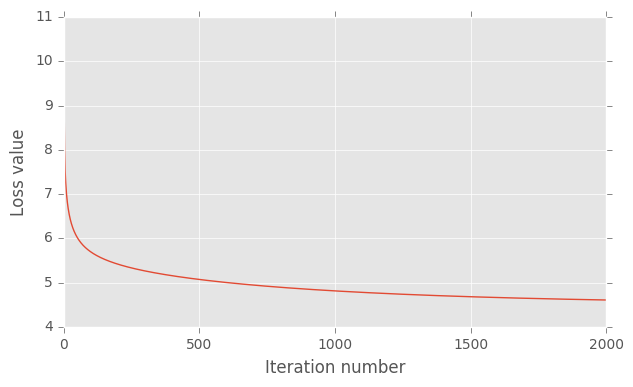

In [189]:
plt.figure(figsize=(7,4))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

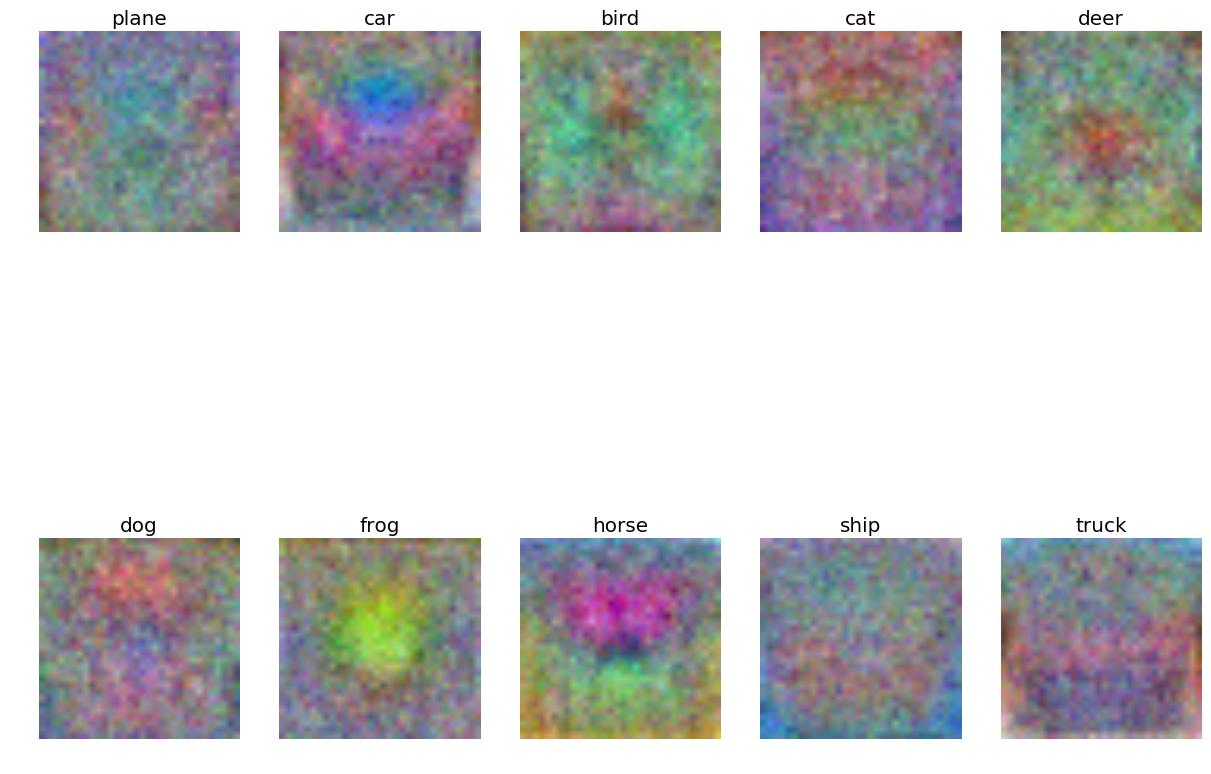

In [190]:
plot_weights(best_svm)

**Задача 4:** О чём говорят полученные изображения? Какие выводы мы можем сделать? Впишите ответ в поле ниже

Матрица W имеет размерность K на D, где K - количество классов, а D - количество признаков.

В нашем случае 10 на 3072 (не учитывая константу). Каждый ряд - это отображение веса при каждом пикселе каждой картинки в разрере трех цветов (RGB).

Рисунки демонстрируют образцы поведения весов для каждого класса. То есть, веса запоминают образы каждого конкретного класса и срабатывают на самый подходящий (дают наивысшую вероятность принадлежности именно к этому классу).

Собственно, эти образы мы и видим на представленных картинках.

Например:
- Веса лягушки имееют зеленое пятно посередине и зелено-коричневые цвета вокруг
- Машина имеет посередине красное снизу и синее сверху пятно (наверное большинство машин в датасете красные)
- Для кораблей и самолетов на картинках с весами присутствует много синего цвета (причем у корабля снизу, а у самолета сверху)
- И тд

**Задача 5:** Повторим упражнение для cross entropy loss

In [115]:
def crossentropy_loss(W, X, y, reg):
    """
    Cross entropy loss function
   Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    y = y.flatten()
    W = W.T
    
    num_examples = X.shape[0]
    
    # Впишите свой код на место заглушки
    loss = 0
    dW = np.zeros(W.shape)
    
    scores = np.dot(X, W)
    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples
    
    dW = np.dot(X.T, dscores)
    dW += reg*W
    
    return loss, dW.T

In [136]:
# Вычисляем значение функции потерь и её градиент для W.
W = np.random.randn(10, 3073) * 0.0001

loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)

In [137]:
# Грубая проверка, значения должны быть близки к -log(0.1).
print('loss: %f'%loss)
print('sanity check: %f'%(-np.log(0.1)))

loss: 2.325728
sanity check: 2.302585


**Задача 6:** Кстати, почему такая проверка справедлива? Объясните

<img src='n3.jpg'>

In [96]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)


f = lambda w: crossentropy_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = crossentropy_loss(W, x_test, y_test, 5e1)
f = lambda w: crossentropy_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.946276 analytic: -3.946276, relative error: 1.068005e-08
numerical: 1.166692 analytic: 1.166692, relative error: 4.902368e-08
numerical: -3.513697 analytic: -3.513697, relative error: 2.222890e-08
numerical: -0.183628 analytic: -0.183628, relative error: 3.636964e-08
numerical: 2.194081 analytic: 2.194081, relative error: 2.121090e-08
numerical: 1.994993 analytic: 1.994993, relative error: 2.287920e-08
numerical: 2.008172 analytic: 2.008172, relative error: 1.123319e-08
numerical: -1.116372 analytic: -1.116372, relative error: 1.611058e-08
numerical: 0.320027 analytic: 0.320027, relative error: 3.074310e-08
numerical: -0.852570 analytic: -0.852570, relative error: 3.676754e-08
numerical: -2.161419 analytic: -2.161419, relative error: 2.326116e-08
numerical: 0.580079 analytic: 0.580079, relative error: 2.608895e-08
numerical: -1.361586 analytic: -1.361586, relative error: 1.628156e-08
numerical: 0.853184 analytic: 0.853184, relative error: 3.550839e-08
numerical: 2.845315 